# Spectrogram

A simple spectrogram for the comparision of pronounciation

In [2]:
import pyaudio
import wave
import numpy as np
from time import sleep

def record_blocking(seconds=-1, channels=2, rate=44100,
                    frames_per_buffer=1024):
    stream = pyaudio.PyAudio().open(
        format=pyaudio.paInt16, channels=channels, input=True,
        rate=rate, frames_per_buffer=frames_per_buffer
    )
    
    frame, total_frames = 0, rate * seconds / frames_per_buffer
    while frame < total_frames or seconds < 0:
        try:
            data = stream.read(frames_per_buffer)
        except OSError as ex:
            if ex.errno != pyaudio.paInputOverflowed:
                raise
            data = b'\x00' * frames_per_buffer
        yield np.frombuffer(data, dtype=np.int16).reshape(-1, channels)
        frame += 1
    stream.stop_stream()
    stream.close()

def record_callback(callback, channels=2, rate=44100,
                    frames_per_buffer=1024):
    def new_callback(data, frame_count, time_info, status):
        new_callback.status = callback(np.frombuffer(data, dtype=np.int16).reshape(-1, channels))
        return b'', new_callback.status
    new_callback.status = pyaudio.paContinue

    p = pyaudio.PyAudio()
    stream = p.open(
        format=pyaudio.paInt16, channels=channels, input=True,
        rate=rate, frames_per_buffer=frames_per_buffer,
        stream_callback=new_callback
    )
    stream.start_stream()
    
    while stream.is_active():
        sleep(0.1)
    
    stream.stop_stream()
    stream.close()
    p.terminate()

# Static Spectrogram

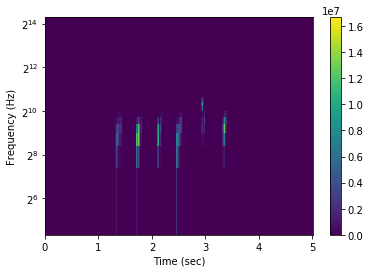

In [45]:
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from matplotlib import rc
from scipy import signal
rc('animation', html='html5')

config = {
    "seconds": 5,
    "rate": 44100, # Hz
    "frames_per_buffer": 1024,
}

fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_yscale('log', basey=2)
sample = np.vstack(list(record_blocking(**config)))
f, t, Sxx = signal.spectrogram(
    np.mean(sample, axis=1),
    fs=config['rate'],
    window=('gaussian', 32.0),
    scaling='spectrum',
)
mesh = ax.pcolormesh(t, f, Sxx)
ax.set_xlabel('Time (sec)')
ax.set_ylabel('Frequency (Hz)')
ax.set_ylim([20, 20e3])
fig.colorbar(mesh)
plt.show()

# Live Spectrogram

<IPython.core.display.Javascript object>


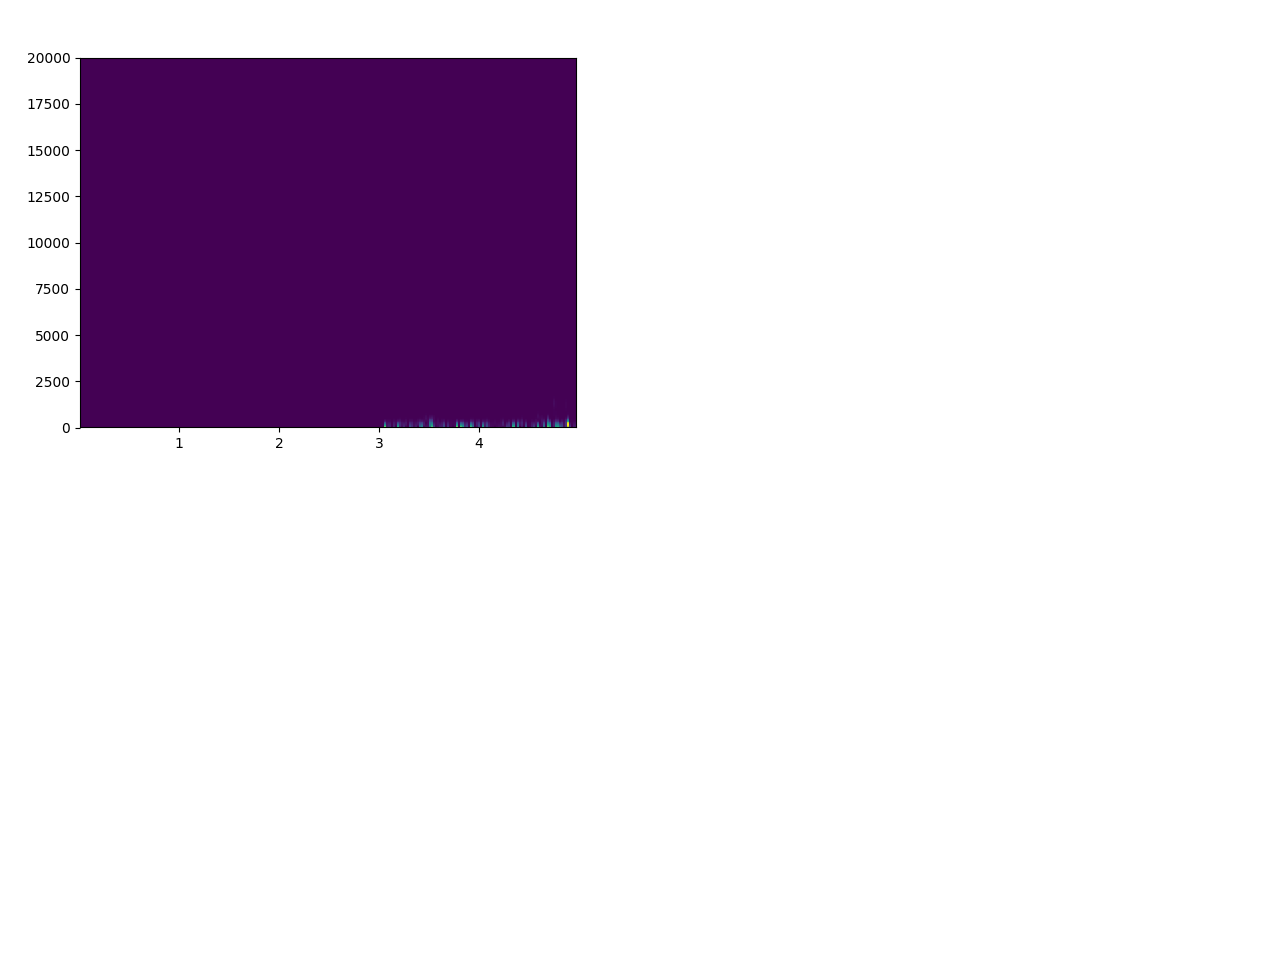

KeyboardInterrupt: 

In [17]:
%matplotlib notebook
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from matplotlib import rc
from scipy import signal
rc('animation', html='html5')
plt.ion()

class LiveSpectogram:
    def __init__(self, rate=44100, nperseg=1024):
        self.fig, self.ax1 = plt.subplots()
        self.ax1.set_yscale('log', basey=2)
        self.ax1.set_ylim([20, 20e3])

        self.fig.show()
        self.fig.canvas.draw()

        self.rate = rate
        self.buffer = np.ones(int(5 * self.rate))
        
        self.state = pyaudio.paContinue
    
    def stop(self):
        self.state = pyaudio.paComplete
    
    def __call__(self, sample):
        #self.ax1.clear()
        data = np.mean(sample, axis=1)
        self.buffer[:-data.shape[0]] = self.buffer[data.shape[0]:]
        self.buffer[self.buffer.shape[0]-data.shape[0]:] = data
        f, t, Sxx = signal.spectrogram(
            self.buffer,
            fs=self.rate,
            nperseg=1024,
            window=('gaussian', 32.0),
            scaling='spectrum',
        )
        self.ax1.pcolormesh(t, f, Sxx)
        self.fig.canvas.draw()
        return self.state

spec = LiveSpectogram()
record_callback(spec)

In [18]:
spec.stop()